# Sequence Models
```{eval-rst}
Last updated |lastupdate|
```
[![Open in Colab](https://img.shields.io/static/v1?logo=google-colab&message=Open%20in%20colab&color=blue&label=%20&labelColor=5c5c5c)](https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/sequence-model.ipynb)

We are going to reproduce the models published in Hie et al. 2021. The fasta file that we will initially work with is hosted in the class bucket, but the full dataset can be donwloaded using the following command:
```bash
wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
tar xvf data.tar.gz
```

Hie, B., Zhong, E. D., Berger, B., & Bryson, B. (2021). [Learning the language of viral evolution and escape.](https://doi.org/10.1126/science.abd7331) *Science*, 371(6526), 284-288.

In [ ]:
!pip install biopython

In [1]:
from Bio import SeqIO
import numpy as np
import pandas as pd
import tensorflow as tf
import umap
import matplotlib.pyplot as plt

## Data Preparation

In [3]:
!wget https://storage.googleapis.com/datasets-spring2021/ird_influenzaA_HA_allspecies.fa

--2021-04-22 20:56:20--  https://storage.googleapis.com/datasets-spring2021/ird_influenzaA_HA_allspecies.fa
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.68.16, 142.250.68.80, 172.217.11.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75204096 (72M) [application/octet-stream]
Saving to: ‘ird_influenzaA_HA_allspecies.fa.5’

100%[======================================>] 75,204,096   100MB/s   in 0.7s   

2021-04-22 20:56:21 (100 MB/s) - ‘ird_influenzaA_HA_allspecies.fa.5’ saved [75204096/75204096]



First we'll collect the sequences and their descriptions in two separate lists.

In [2]:
# File paths for influenze sequences and metadata
fpath = 'ird_influenzaA_HA_allspecies.fa' 

seqs, dscr, length = [],[],[]
for record in SeqIO.parse(fpath, 'fasta'):
    seqs.append(record.seq)
    dscr.append(record.description)
    length.append(len(record))

len(seqs)

94560

## Process Metadata
Each sequence carries a text based description that we collected in a list. We can pass it into a pandas dataframe and then parse out useful information.

In [16]:
df = pd.DataFrame({'description':dscr})
df.head()

,description
0,gb:K00429|ncbiId:AAR96248.1|UniProtKB:Q6LEJ4|O...
1,gb:J02176|ncbiId:AAA43209.1|UniProtKB:P03454|O...
2,gb:CY021709|ncbiId:ABP49327.1|UniProtKB:A4U6V2...
3,gb:CY020285|ncbiId:ABO38054.1|UniProtKB:A4GBW6...
4,gb:CY083910|ncbiId:ADX98960.1|UniProtKB:F0TT51...


In [17]:
df.iloc[0].values

array(['gb:K00429|ncbiId:AAR96248.1|UniProtKB:Q6LEJ4|Organism:Influenza A virus (A/seal/Mass/1/1980(H7N7))|Strain Name:A/seal/Mass/1/1980|Protein Name:HA Hemagglutinin|Gene Symbol:HA|Segment:4|Subtype:H7N7|Host:Sea Mammal'],
      dtype=object)

Pandas has useful [functions for parsing string data](https://pandas.pydata.org/pandas-docs/stable/reference/series.html#string-handling) which we will leverate to turn the description into a table of metadata.

In [18]:
# Extract column names
cols = [i.split(':')[0] for i in df.iloc[0].values[0].split('|')]
cols

['gb',
 'ncbiId',
 'UniProtKB',
 'Organism',
 'Strain Name',
 'Protein Name',
 'Gene Symbol',
 'Segment',
 'Subtype',
 'Host']

In [19]:
# Split description at | and expand into separate columns
df[cols] = df['description'].str.split('|',expand=True)
df.head()

,description,gb,ncbiId,UniProtKB,Organism,Strain Name,Protein Name,Gene Symbol,Segment,Subtype,Host
0,gb:K00429|ncbiId:AAR96248.1|UniProtKB:Q6LEJ4|O...,gb:K00429,ncbiId:AAR96248.1,UniProtKB:Q6LEJ4,Organism:Influenza A virus (A/seal/Mass/1/1980...,Strain Name:A/seal/Mass/1/1980,Protein Name:HA Hemagglutinin,Gene Symbol:HA,Segment:4,Subtype:H7N7,Host:Sea Mammal
1,gb:J02176|ncbiId:AAA43209.1|UniProtKB:P03454|O...,gb:J02176,ncbiId:AAA43209.1,UniProtKB:P03454,Organism:Influenza A virus (A/WSN/1933(H1N1)),Strain Name:A/WSN/1933,Protein Name:HA Hemagglutinin,Gene Symbol:HA,Segment:4,Subtype:H1N1,Host:Human
2,gb:CY021709|ncbiId:ABP49327.1|UniProtKB:A4U6V2...,gb:CY021709,ncbiId:ABP49327.1,UniProtKB:A4U6V2,Organism:Influenza A virus (A/AA/Huston/1945(H...,Strain Name:A/AA/Huston/1945,Protein Name:HA Hemagglutinin,Gene Symbol:HA,Segment:4,Subtype:H1N1,Host:Human
3,gb:CY020285|ncbiId:ABO38054.1|UniProtKB:A4GBW6...,gb:CY020285,ncbiId:ABO38054.1,UniProtKB:A4GBW6,Organism:Influenza A virus (A/AA/Marton/1943(H...,Strain Name:A/AA/Marton/1943,Protein Name:HA Hemagglutinin,Gene Symbol:HA,Segment:4,Subtype:H1N1,Host:Human
4,gb:CY083910|ncbiId:ADX98960.1|UniProtKB:F0TT51...,gb:CY083910,ncbiId:ADX98960.1,UniProtKB:F0TT51,Organism:Influenza A virus (A/Aalborg/INS132/2...,Strain Name:A/Aalborg/INS132/2009,Protein Name:HA Hemagglutinin,Gene Symbol:HA,Segment:4,Subtype:H1N1,Host:Human


In [20]:
# Remove prefix from each entry in the description based on spliting at the colon :
for c in cols:
    df[c] = df[c].str.lstrip(c+':')

df.head()

,description,gb,ncbiId,UniProtKB,Organism,Strain Name,Protein Name,Gene Symbol,Segment,Subtype,Host
0,gb:K00429|ncbiId:AAR96248.1|UniProtKB:Q6LEJ4|O...,K00429,AAR96248.1,Q6LEJ4,Influenza A virus (A/seal/Mass/1/1980(H7N7)),A/seal/Mass/1/1980,HA Hemagglutinin,HA,4,H7N7,Sea Mammal
1,gb:J02176|ncbiId:AAA43209.1|UniProtKB:P03454|O...,J02176,AAA43209.1,03454,Influenza A virus (A/WSN/1933(H1N1)),A/WSN/1933,HA Hemagglutinin,HA,4,H1N1,uman
2,gb:CY021709|ncbiId:ABP49327.1|UniProtKB:A4U6V2...,CY021709,ABP49327.1,A4U6V2,Influenza A virus (A/AA/Huston/1945(H1N1)),A/AA/Huston/1945,HA Hemagglutinin,HA,4,H1N1,uman
3,gb:CY020285|ncbiId:ABO38054.1|UniProtKB:A4GBW6...,CY020285,ABO38054.1,A4GBW6,Influenza A virus (A/AA/Marton/1943(H1N1)),A/AA/Marton/1943,HA Hemagglutinin,HA,4,H1N1,uman
4,gb:CY083910|ncbiId:ADX98960.1|UniProtKB:F0TT51...,CY083910,ADX98960.1,F0TT51,Influenza A virus (A/Aalborg/INS132/2009(H1N1)),A/Aalborg/INS132/2009,HA Hemagglutinin,HA,4,H1N1,uman


## Process Sequences

Now we can return to the sequences and take a look at an example.

In [10]:
seqs[0]

Seq('MNTQILVFIACVLIEAKGDKICLGHHAVANGTKVNTLTERGIEVVNATETVETA...ICI')

In order to begin efficiently working with these sequences, we need to convert them to an array and a numeric encoding.

In [3]:
AAs = [
        'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
        'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
        'Y', 'V', 'X', 'Z', 'J', 'U', 'B', 'Z'
    ]
vocabulary = { aa: idx + 1 for idx, aa in enumerate(sorted(AAs)) }

seqs_pre = []
for s in seqs:
    seqs_pre.append(
        [vocabulary[a] for a in s]
    )

The model is ultimately trained by asking it to predict the identiy of an amino acid at position $i$ based on the sequence before $X[:i]$ or after $X[i+1:]$ it. We need a utility function to take each sequence in our dataset and split it at each possible position in order to create the training dataset. For this purpose, we are only going to train on a small fraction of the dataset so that we can keep the memory usage manageable. We will use numpy to generate a list of random indicies that we will use to randomly select a subset of our data.

In [4]:
def split_and_pad(seqs,seq_len):
    '''For each seq, split at each possible amino acid position 
    into pre and post sequences'''

    # Split each sequence at each possible index i
    X_pre = [s[:i] for s in seqs for i in range(len(s))]
    X_post = [s[i+1:] for s in seqs for i in range(len(s))]
    y = np.array([s[i] for s in seqs for i in range(len(s))])

    # Pad X_pre and X_post with pre or post padding respectively
    X_pre = tf.keras.preprocessing.sequence.pad_sequences(
        X_pre, maxlen=seq_len, padding='pre', truncating='pre', value=0
    )
    X_post = tf.keras.preprocessing.sequence.pad_sequences(
        X_post, maxlen=seq_len, padding='post', truncating='post', value=0
    )

    # Flip X_post values
    X_post = np.flip(X_post, 1)

    # Stack X into single array
    X = np.stack([X_pre, X_post],axis=-1)

    return X, y

# Generate random selection
selector = np.random.choice(len(seqs_pre),size=1000)
subset = [seqs_pre[i] for i in selector]

X, y = split_and_pad(subset, max(length)-1)
print(X.shape, y.shape)

(565017, 575, 2) (565017,)


We can now pass our data into a tf.Dataset object to facilitate training.

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(((X[...,0],X[...,1]),y))

If we look at a single `take` from the dataset, we can see a padded sequence with numeric encoding.

In [14]:
for i in dataset.take(1):
    print(i)

((<tf.Tensor: shape=(575,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

## Build Model
In the paper, they test a several model architectures and a variety of hyperparameters before ultimately selecting a BiLSTM architecture with two hidden layers of 512 units each. The model receives sequence context for before and after the missing amino acid.

In [6]:
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def BiLSTM(seq_len, 
           vocab_size,
           embedding_dim=20,
           hidden_dim=256,
           n_hidden=2):

    # Define input layers
    input_pre = Input(shape=(seq_len,))
    input_post = Input(shape=(seq_len,))

    # Generate embedding layer and run both inputs through
    embed = layers.Embedding(vocab_size, embedding_dim, input_length=seq_len)
    xpre = embed(input_pre)
    xpost = embed(input_post)

    # Generate an lstm layer for each hidden dimension
    for _ in range(n_hidden-1):
        lstm = layers.LSTM(hidden_dim, return_sequences=True)
        xpre = lstm(xpre)
        xpost = lstm(xpost)

    # Define final LSTM layer
    lstm = layers.LSTM(hidden_dim)
    xpre = lstm(xpre)
    xpost = lstm(xpost)

    # Concatenate pre and post before sending to dense
    x = layers.concatenate([xpre, xpost], name='embed_layer')
    x = layers.Dense(vocab_size)(x)
    output = layers.Activation('softmax')(x)

    bilstm = Model(inputs=[input_pre, input_post], outputs=output)

    return bilstm

model = BiLSTM(X.shape[1],len(vocabulary))

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 575)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 575)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 575, 20)      500         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 575, 256)     283648      embedding[0][0]              

In [8]:
from tensorflow.keras.optimizers import Adam

n_epochs = 6
batch_size = 100

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

MODEL_PATH = 'flu-sequence-20210330-epoch{epoch:02d}.h5'

In [ ]:
model.fit(dataset.shuffle(2000).batch(batch_size),
          epochs=n_epochs,
          callbacks=[tf.keras.callbacks.ModelCheckpoint(
            MODEL_PATH,
            monitor='accuracy',
            verbose=1,
            save_best_only=True)])

Epoch 1/6
1307/5652 [=====>........................] - ETA: 11:20:56 - loss: 2.7632 - accuracy: 0.1359

The model was ultimately trained for 6 epochs to get started on the training process.

## Sample Embeddings
We are now ready to use hidden layer to extract the semantic embeddings of sequences.

In [ ]:
# Download weights file from bucket
!wget https://storage.googleapis.com/datasets-spring2021/flu-sequence-20210330-epoch2-04.h5

In [9]:
model.load_weights('flu-sequence-20210330-epoch2-04.h5')

In [10]:
# Retrieve hidden layer to use for the embedding
hidden = tf.keras.backend.function(
    inputs=model.input,
    outputs=model.get_layer('embed_layer').output
)

# Run predictions in batches to manage memory
x_embed_list = []
for i in range(0,X.shape[0],5000):
    print(".", end="")
    end = min(i+5000, X.shape[0])
    x_embed_list.append(hidden([X[i:end,:,0],X[i:end,:,0]]))
x_embed_cat = np.concatenate(x_embed_list)
x_embed_cat.shape

..................................................................................................................

(565017, 512)

Currently the first axis is representative of all sequences concatenated together. We can reshape to introduce the sample axis.

In [11]:
x_embed = np.stack([
    x_embed_cat[i:i+575]
    for i in range(0,(X.shape[0]//575)*575,575)
])
x_embed.shape

(982, 575, 512)

Finally, we take find the average value of the sequence for each of the 512 dimensions in the last axis.

In [12]:
xmean = x_embed.mean(1)
xmean.shape

(982, 512)

In [13]:
np.savez_compressed('xmean.npz',xmean=xmean)

The paper elects to use the UMAP algorithm to reduce the data from 512 dimensions to 2 which can be easily visualized. We will use the [python package](https://github.com/lmcinnes/umap) that was published with the original paper.

In [14]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(xmean)
embedding.shape

(982, 2)

In order to produce visualizations that we can begin to interpret, we will link our embeddings back to the original metadata that we collected about each sequence.

In [22]:
df_embed = df.iloc[:982]
df_embed['embed_0'] = embedding[:,0]
df_embed['embed_1'] = embedding[:,1]

<ipython-input-22-de86a6874aaa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embed['embed_0'] = embedding[:,0]
<ipython-input-22-de86a6874aaa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embed['embed_1'] = embedding[:,1]


For an initial visualization, we will plot each sequence and color code according to the viral subtype.

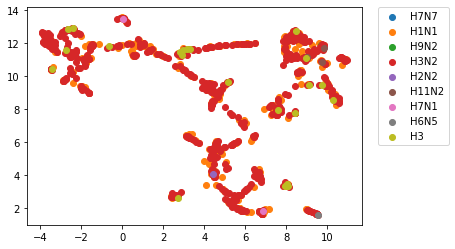

In [23]:
fig,ax = plt.subplots()
for i,cat in enumerate(df_embed['Subtype'].unique()):
    indx = df_embed['Subtype'] == cat
    ax.scatter(df_embed['embed_0'].loc[indx],df_embed['embed_1'].loc[indx],label=cat)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)